# Style Transfer
[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage, Resize, CenterCrop, Compose, Normalize

# The images

In [3]:
"""
Some helper functions
"""
toPIL = ToPILImage()
means = torch.tensor([0.485, 0.456, 0.406])
stds = torch.tensor([0.229, 0.224, 0.225])
h=225
w=400

trans = Compose([
        Resize((h,w)),
        ToTensor(),
        Normalize(means, stds)
])

def untrans(img):
    img = img * stds.reshape(1,3,1,1) + means.reshape(1,3,1,1)
    return toPIL(img.squeeze())
    

def splot(img, i=1, r=1, c=1):
    plt.subplot(r,c,i)
    try:
        plt.imshow(img)
    except:
        plt.imshow(untrans(img))
    plt.axis('off')

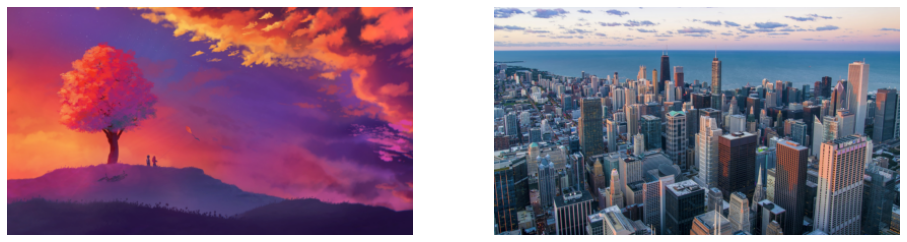

In [4]:
"""
Get the images
"""

styl_ = Image.open("./style.jpg")
cont_ = Image.open("./content.jpeg")

styl = trans(styl_).unsqueeze(0)
cont = trans(cont_).unsqueeze(0)

# Display the images
plt.figure(figsize=(16,9))
splot(styl,1,1,2),splot(cont,2,1,2)
plt.show()

Photo by [Pedro Lastra](https://unsplash.com/@peterlaster?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on Unsplash  
Art by [auroralion](https://www.deviantart.com/auroralion)

# The network

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchsummary import summary

In [6]:
model__ = vgg19(pretrained=True).eval()
model_ = [*model__.children()][0]
layers = []

# Replace MaxPool with AvgPool like in the paper (better grad flow)
for ch in model_.children():
    if isinstance(ch,nn.MaxPool2d):
        d = {
            'kernel_size' : ch.kernel_size,
            'stride' : ch.stride,
            'padding' : ch.padding,
            'ceil_mode' : ch.ceil_mode
        }
        layers.append(nn.AvgPool2d(**d))
    elif isinstance(ch, nn.ReLU):
        # Works better acc to 
        # https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
        layers.append(nn.ReLU(inplace=False)) 
    else:
        layers.append(ch)
        
model_ = nn.Sequential(*layers)
del layers

In [7]:
def forward(x, model=model_):
    """
    Get activations for all conv layers
    """
    fp = []
    for child in model.children():
        x = child(x)
        if isinstance(child, (nn.Conv2d)):
            fp.append(x)
    return fp

def get_layers(model):
    for m in model.modules():
        if len([*m.children()]) == 0:
            yield m

def get_gram(act):
    nc = torch.tensor(act.size()).prod()
    act = act.reshape(act.size(1), -1)
    return (act @ act.T)/nc

def get_grams(acts):
    return [get_gram(act) for act in acts]

In [8]:
class ContentCost(nn.Module):
    def __init__(self, cont_act):
        super().__init__()
        # Reference activation.
        self.ref = cont_act.detach()
        self.lfn = lambda x: F.mse_loss(x, self.ref)
        
    def forward(self, x_act):
        self.loss =  self.lfn(x_act)
        return x_act
    
class StyleCost(nn.Module):
    def __init__(self, styl_act, lambd=1):
        super().__init__()
        # Reference gram matrix.
        self.ref = get_gram(styl_act).detach()
        self.lambd = lambd
        self.lfn = lambda x: F.mse_loss(x, self.ref)
        
    def forward(self, x_act):
        x_gram = get_gram(x_act)
        self.loss = self.lfn(x_gram) * self.lambd
        return x_act

In [9]:
content_index = 4
style_indices = [1,2,3,4,5]

class StyleTransfer(nn.Module):
    def __init__(self, content_image, style_image, lambd=None, style_indices=style_indices, 
                 content_index=content_index, model=model_):
        super().__init__()
        activations = {
            "content":forward(content_image,model),
            "style":  forward(style_image,model),
        }
        if lambd is None:
            lambd = [1]*len(style_indices)
        self._prepare_model(model, activations, content_index, style_indices, lambd)
        
    def _prepare_model(self, model, activations, content_index, style_indices, lambd):
        layers = []
        i = 0
        for layer in model.children():
            if isinstance(layer, nn.Conv2d):
                layers.append(layer)
                if i in style_indices:
                    sc = StyleCost(activations["style"][i].detach(), lambd.pop(0))
                    layers.append(sc)
                if i == content_index:
                    cc = ContentCost(activations["content"][i].detach())
                    layers.append(cc)
                i += 1
                if i > content_index and i > max(style_indices):
                    break
            else:
                layers.append(layer)
        self.model = nn.Sequential(*layers).eval()
        
    def loss(self, alpha=None, beta=None):
        cl = 0
        sl = 0
        for ch in self.model:
            if isinstance(ch, ContentCost):
                cl += ch.loss
            if isinstance(ch, StyleCost):
                sl += ch.loss
        if alpha is None or beta is None:
            return cl, sl
        else:
            return alpha*cl + beta*sl
    
    def forward(self, x):
        return self.model(x)

# Getting the Image

In [10]:
from tqdm.autonotebook import tqdm
from torch import optim

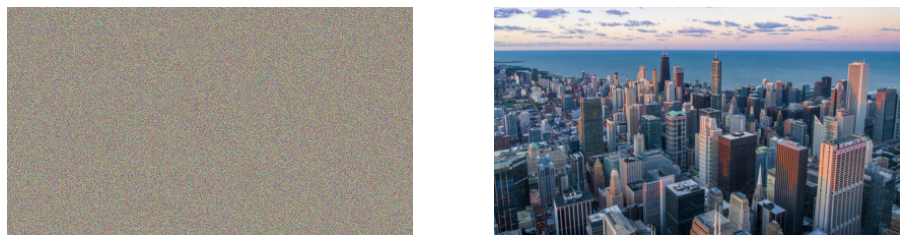

In [60]:
model = StyleTransfer(cont, styl)

target = torch.rand(styl.shape,requires_grad=True)
target2 = cont.clone()
target2.requires_grad_(True)

opt = optim.SGD([target],lr = 100)
opt2 = optim.SGD([target2],lr = 100)

losses = []

plt.figure(figsize=(16,5))
splot(target,1,1,2)
splot(target2,2,1,2)
plt.show()

In [15]:
opt.param_groups[0]['lr'] = 100

In [61]:
def fit(target, epochs, optimizer=opt, alpha=1, beta=5e3,  model=model,  losses=losses):
    pbar = tqdm(total=epochs)
    run = [0]
    for i in range(epochs):
        # Keeps the target within range
        target.data.clamp_(0,1)
        optimizer.zero_grad()
        model(target)
        loss = model.loss(alpha, beta)
        loss.backward()
        optimizer.step()

        # Update tqdm
        pbar.desc = f"{loss.item():0.4f}"
        pbar.update(1)
        losses.append(loss.item())
    target.data.clamp_(0,1)

In [84]:
fit(target, 100, opt, alpha=1, beta=1000)

In [85]:
fit(target2, 100, opt2, alpha=1, beta=1000, losses = [])

In [71]:
def mmn(img):
    img = img.clone()
    img -= img.min()
    img /= img.max()
    img *= 255
    return img.squeeze().long().numpy().transpose(1,2,0)

tr = lambda x: toPIL(x.squeeze())

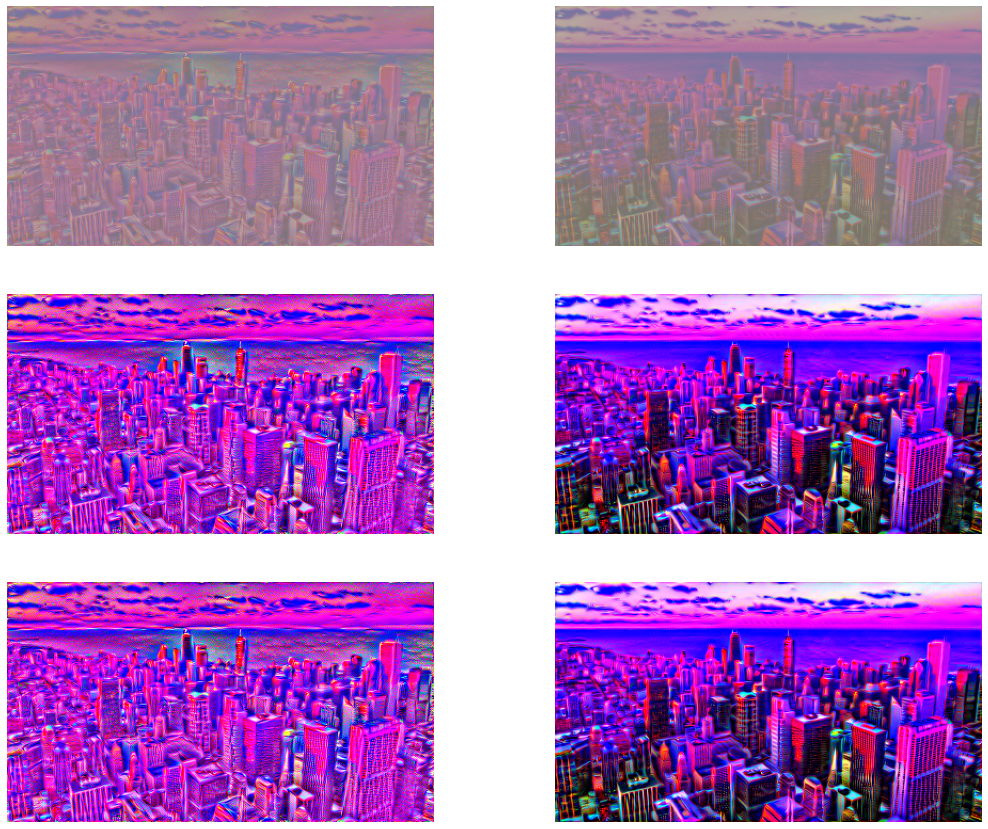

In [86]:
plt.figure(figsize=(18,15))
splot(target,1,3,2)
splot(target2,2,3,2)
splot(tr(target),3,3,2)
splot(tr(target2),4,3,2)
splot(mmn(target),5,3,2)
splot(mmn(target2),6,3,2)
plt.show()

## Experiment list
- Use a style image that has more texture
- A content image with some regions of low texture
- See what happens when more layers are accounted for.
- See what happens when either style or content cost is set to zero.
- See what happens when the target image is either noise, content image, style image.
- Find the best set of params then run the experiments using those, maybe use LBFGS
- Different layers being used for content cost
- Different layers being used for style cost